# Feature Engineering

## Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

## Data Loading

In [2]:
orders = pd.read_csv('data/orders.csv')

## Data Imputation

### Missing Values

From EDA, we know that the column `days_since_prior_order` has missing values. So let's take a look at it.

In [3]:
def select_records_of_user_with_missing_values() -> pd.DataFrame:
    """
    Select a random user with missing values in the `days_since_prior_order` column
    and return all records of that user.

    Returns:
        pd.DataFrame: DataFrame containing all records of the selected user.
    """
    # Find users with missing values in the `days_since_prior_order` column
    users_with_missing_values = orders[orders['days_since_prior_order'].isnull()]['user_id'].unique()
    # Select a random user from the list
    random_user = np.random.choice(users_with_missing_values)
    # Return all records of the selected user
    return orders[orders['user_id'] == random_user]

In [4]:
select_records_of_user_with_missing_values()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,number_of_products
2414708,697484,154591,1,5,12,NaN,3
2414709,3398721,154591,2,5,7,30.0,2
2414710,1907792,154591,3,4,8,30.0,3
2414711,2435390,154591,4,5,10,1.0,1
2414712,1858194,154591,5,1,9,3.0,1


In [5]:
select_records_of_user_with_missing_values()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,number_of_products
1464639,759388,93594,1,1,12,NaN,18
1464640,957824,93594,2,3,7,9.0,4
1464641,2691181,93594,3,1,22,19.0,25
1464642,1044614,93594,4,3,10,9.0,25
1464643,2936856,93594,5,2,16,20.0,27
1464644,1086726,93594,6,0,17,5.0,26
1464645,1973839,93594,7,0,16,14.0,27
1464646,2839520,93594,8,2,22,9.0,31
1464647,2540156,93594,9,4,15,9.0,19
1464648,1520700,93594,10,3,16,6.0,26


It looks like the first order of each user has a missing value in the `days_since_prior_order` column. This makes sense because there is no prior order to calculate the days since. Let's check if this is true for all users.

If this is true:
  - There should be exactly one missing value per user.
  - The missing value should be in the first order of each user.

In [6]:
# Check if there is exactly one missing value per user
missing_values_count = orders[orders['days_since_prior_order'].isnull()].groupby('user_id').size()
assert all(missing_values_count == 1), "There is at least one user with more than one missing value."

In [7]:
# Check if the missing value is in the first order of each user
first_orders = orders.groupby('user_id')['order_number'].min()
first_orders_with_missing_values = orders[orders['days_since_prior_order'].isnull()].set_index('user_id')['order_number']
assert all(first_orders == first_orders_with_missing_values), "There is at least one user whose first order does not have a missing value."

This validates our assumption. Now, we can fill the missing values with 0, indicating that there are 0 days since the prior order for the first order.

In [8]:
orders.fillna({'days_since_prior_order': 0}, inplace=True)

In [9]:
print(orders.isna().sum())

order_id                  0
user_id                   0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
number_of_products        0
dtype: int64


### Outliers

- We observed in EDA that a huge number of orders have `days_since_prior_order` equal to 30.
- There are a few possibilities. For example :
  - There is a subscription model where users get their orders every 30 days.
  - System limitation where the maximum value that can be recorded is 30.
- This is probably the time, we should reach out to the data provider to understand the context.
- As we don't have that option, we will treat these values as valid, and we will not impute them.

## Feature Creation

Let's refresh the types and levels of measurement of different variables in the dataset.

|        Feature         |      Type      |  Level of Measurement  |
|:----------------------:|:--------------:|:----------------------:|
|        Order ID        |  Categorical   |        Nominal         |
|        User ID         |  Categorical   |        Nominal         |
|      Order Number      |  Quantitative  |         Ratio          |
|   Order Day of Week    |  Categorical   |        Ordinal         |
|   Order Hour of Day    |  Quantitative  |         Ratio          |
| Days Since Prior Order |  Quantitative  |         Ratio          |
|   Number of Products   |  Quantitative  |         Ratio          |

This helps us to decide which features we can create and how.

In [10]:
# Let's start with a dataframe containing unique users
features = orders[['user_id']].drop_duplicates().reset_index(drop=True).copy(deep=True)
features.head()

,user_id
0,1
1,2
2,3
3,4
4,5


### Features corresponding to `order_number`

- Let's keep it simple and create just one feature.
- Feature : `total_orders`.
- This will be a quantitative variable with ratio level of measurement.

In [11]:
# Feature : `total_orders`
total_orders = orders.groupby('user_id').size().reset_index().copy(deep=True)
total_orders.rename(columns={0: 'total_orders'}, inplace=True)
features = features.merge(total_orders, on='user_id', how='left')
features.head()

,user_id,total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


### Features corresponding to `order_dow`

`order_dow` is a categorical variable with ordinal level of measurement.
  - This implies statistics like mean, and median for `order_dow` of each user are defined.
  - Mode is more appropriate in this case as it represents the most frequent day of the week a user places an order.

In [12]:
most_frequent_order_dow = orders.groupby('user_id')['order_dow'].agg(lambda x: x.mode().iloc[0]).reset_index()
features = features.merge(most_frequent_order_dow, on='user_id', how='left')
features.rename(columns={'order_dow': 'most_frequent_order_dow'}, inplace=True)
features.most_frequent_order_dow.value_counts() # To ensure no NaN values were introduced

most_frequent_order_dow
0    63078
1    45476
2    24464
6    21225
3    18777
5    17480
4    15709
Name: count, dtype: int64

The feature `most_frequent_order_dow` is also a categorical variable with ordinal level of measurement.

During our EDA, we observed that days `0` and `1` have the highest number of orders.
  - Let's call these days `peak_dow`.
  - One interesting feature could be to check what percentage of orders a user places on `peak_dow`.



In [13]:
peak_dow = [0, 1]
peak_dow_order_ratio = orders[orders['order_dow'].isin(peak_dow)].groupby('user_id').size() / orders.groupby('user_id').size()
peak_dow_order_ratio = peak_dow_order_ratio.reset_index().copy(deep=True)
features = features.merge(peak_dow_order_ratio, on='user_id', how='left')
features.rename(columns={0: 'peak_dow_order_ratio'}, inplace=True)
features.fillna({'peak_dow_order_ratio': 0.0}, inplace=True)
features['peak_dow_order_ratio'] = features['peak_dow_order_ratio'].round(2)

The feature `peak_dow_order_ratio` is a quantitative variable with ratio level of measurement.

We can create a lot of other features. However, we will limit ourselves to these two features for now.

### Features corresponding to `order_hour_of_day`

We can follow a similar approach as `order_dow`.

- Feature 1 :
    - Median order hour of day for each user.
    - This will be a quantitative variable with ratio level of measurement.
    - As this is a quantitative variable with ratio level of measurement, median is defined.
- Feature 2 :
    - Ratio of orders placed during peak hours.
    - This will be a quantitative variable with ratio level of measurement.
    - From EDA, we know that 50% of orders are placed between 10.0 and 16.0. Let's call these hours peak hours.

In [14]:
# Feature 1 : `median_order_hour_of_day`
median_order_hour_of_day = orders.groupby('user_id')['order_hour_of_day'].median().reset_index().copy(deep=True)
median_order_hour_of_day.rename(columns={'order_hour_of_day': 'median_order_hour_of_day'}, inplace=True)
features = features.merge(median_order_hour_of_day, on='user_id', how='left')
features['median_order_hour_of_day'] = features['median_order_hour_of_day'].round(2)

In [15]:
# Feature 2 : `peak_hour_order_ratio`
peak_hours = range(10, 17)
peak_hour_order_ratio = orders[orders['order_hour_of_day'].isin(peak_hours)].groupby('user_id').size() / orders.groupby('user_id').size()
peak_hour_order_ratio = peak_hour_order_ratio.reset_index().copy(deep=True)
features = features.merge(peak_hour_order_ratio, on='user_id', how='left')
features.rename(columns={0: 'peak_hour_order_ratio'}, inplace=True)
features.fillna({'peak_hour_order_ratio': 0.0}, inplace=True)
features['peak_hour_order_ratio'] = features['peak_hour_order_ratio'].round(2)

### Features corresponding to `days_since_prior_order`

- `days_since_prior_order` is a quantitative variable with ratio level of measurement.
- As the ratio is defined, we can calculate mean / median.
- Let's create the feature `median_days_since_prior_order`.
- This will be a quantitative variable with ratio level of measurement.

In [16]:
median_days_since_prior_order = orders.groupby('user_id')['days_since_prior_order'].median()
median_days_since_prior_order = median_days_since_prior_order.reset_index().copy(deep=True)
median_days_since_prior_order.rename(columns={'days_since_prior_order': 'median_days_since_prior_order'}, inplace=True)
features = features.merge(median_days_since_prior_order, on='user_id', how='left')
features['median_days_since_prior_order'] = features['median_days_since_prior_order'].round(2)

### Features corresponding to `number_of_products`

- Feature 1 : `median_number_of_products`
    - Median number of products per order for each user.
    - This will be a quantitative variable with ratio level of measurement.

- Feature 2 : `peak_dow_product_ratio`
    - Ratio of products ordered on peak days of the week to total products ordered.
    - This will be a quantitative variable with ratio level of measurement.

- Feature 3 : `peak_hour_product_ratio`
    - Ratio of products ordered during peak hours to total products ordered.
    - This will be a quantitative variable with ratio level of measurement.

- Feature 4 : `small_order_ratio`
    - Ratio of small orders (< 5) to total orders.
    - The number is from the quantile analysis done during EDA.
    - This will be a quantitative variable with ratio level of measurement.

- Feature 5 : `large_order_ratio`
    - Ratio of large orders (> 14) to total orders.
    - The number is from the quantile analysis done during EDA.
    - This will be a quantitative variable with ratio level of measurement.

In [17]:
# Feature 1 : `median_number_of_products`
median_number_of_products = orders.groupby('user_id')['number_of_products'].median()
median_number_of_products = median_number_of_products.reset_index().copy(deep=True)
median_number_of_products.rename(columns={'number_of_products': 'median_number_of_products'}, inplace=True)
features = features.merge(median_number_of_products, on='user_id', how='left')
features['median_number_of_products'] = features['median_number_of_products'].round(2)

In [18]:
# Feature 2 : `peak_dow_product_ratio`
peak_dow_products = orders[orders['order_dow'].isin(peak_dow)].groupby('user_id')['number_of_products'].sum()
total_products = orders.groupby('user_id')['number_of_products'].sum()
peak_dow_product_ratio = (peak_dow_products / total_products).reset_index().copy(deep=True)
peak_dow_product_ratio.rename(columns={'number_of_products': 'peak_dow_product_ratio'}, inplace=True)
features = features.merge(peak_dow_product_ratio, on='user_id', how='left')
features.fillna({'peak_dow_product_ratio': 0.0}, inplace=True)
features['peak_dow_product_ratio'] = features['peak_dow_product_ratio'].round(2)

In [19]:
# Feature 3 : `peak_hour_product_ratio`
peak_hour_products = orders[orders['order_hour_of_day'].isin(peak_hours)].groupby('user_id')['number_of_products'].sum()
peak_hour_product_ratio = (peak_hour_products / total_products).reset_index().copy(deep=True)
peak_hour_product_ratio.rename(columns={'number_of_products': 'peak_hour_product_ratio'}, inplace=True)
features = features.merge(peak_hour_product_ratio, on='user_id', how='left')
features.fillna({'peak_hour_product_ratio': 0.0}, inplace=True)
features['peak_hour_product_ratio'] = features['peak_hour_product_ratio'].round(2)

In [20]:
# Feature 4 : `small_order_ratio`
small_orders = orders[orders['number_of_products'] < 5].groupby('user_id').size()
total_orders = orders.groupby('user_id').size()
small_order_ratio = (small_orders / total_orders).reset_index().copy(deep=True)
small_order_ratio.rename(columns={0: 'small_order_ratio'}, inplace=True)
features = features.merge(small_order_ratio, on='user_id', how='left')
features.fillna({'small_order_ratio': 0.0}, inplace=True)
features['small_order_ratio'] = features['small_order_ratio'].round(2)

In [21]:
# Feature 5 : `large_order_ratio`
large_orders = orders[orders['number_of_products'] > 14].groupby('user_id').size()
large_order_ratio = (large_orders / total_orders).reset_index().copy(deep=True)
large_order_ratio.rename(columns={0: 'large_order_ratio'}, inplace=True)
features = features.merge(large_order_ratio, on='user_id', how='left')
features.fillna({'large_order_ratio': 0.0}, inplace=True)
features['large_order_ratio'] = features['large_order_ratio'].round(2)

## Feature Finalization

In [22]:
features.set_index('user_id', inplace=True)

Let's check the feature we have created.

|            Feature            |     Type     | Level of Measurement |
|:-----------------------------:|:------------:|:--------------------:|
|    most_frequent_order_dow    | Categorical  |       Ordinal        |
|     peak_dow_order_ratio      | Quantitative |        Ratio         |
|   median_order_hour_of_day    | Quantitative |        Ratio         |
|     peak_hour_order_ratio     | Quantitative |        Ratio         |
| median_days_since_prior_order | Quantitative |        Ratio         |
|   median_number_of_products   | Quantitative |        Ratio         |
|    peak_dow_product_ratio     | Quantitative |        Ratio         |
|    peak_hour_product_ratio    | Quantitative |        Ratio         |
|       small_order_ratio       | Quantitative |        Ratio         |
|       large_order_ratio       | Quantitative |        Ratio         |
|         total_orders          | Quantitative |        Ratio         |

- Out of this `most_frequent_order_dow` is a categorical variable with ordinal level of measurement.
- Others are quantitative variables with ratio level of measurement.
- When we have mixed types of variables, the clustering algorithm of choice gets tricky.
- There a few ways to handle this :
  - Use `one-hot-encoding` to convert `most_frequent_order_dow` to a set of binary variables.
  - Add features that corresponds to number of orders placed on each day of the week by the user.
  - Add features that corresponds to ratio of orders placed on each day of the week by the user to total orders by the user.
  - Simply drop the variable.
- Let's revisit this after we finish analysis with the current set of features.

Let's check the distribution of different features.

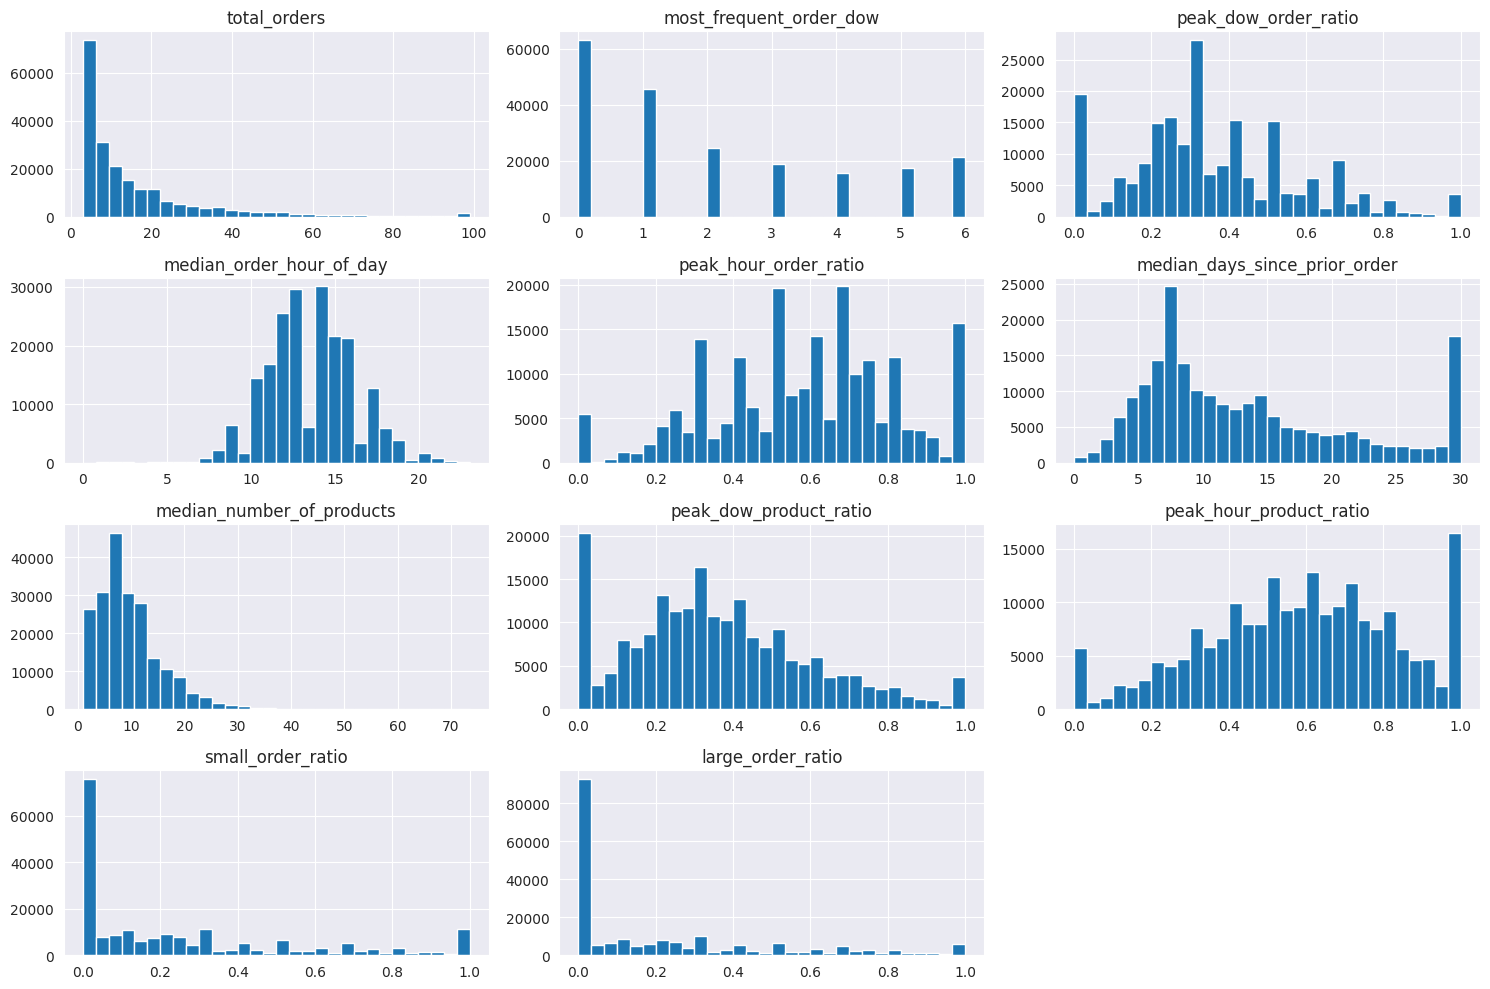

In [23]:
features.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

- Let's use log transformation to reduce the skewness of the features : `total_orders`, and `median_number_of_products`.

In [24]:
# Let's add log transformation to : `total_orders`, `median_number_of_products`, `small_order_ratio`
features['log_total_orders'] = np.log1p(features['total_orders'])
features['log_median_number_of_products'] = np.log1p(features['median_number_of_products'])
features.drop(columns=['total_orders', 'median_number_of_products'], inplace=True)

- `small_order_ratio`, and `large_order_ratio` is also skewed. However, most values are concentrated near 0.
- Let's binarize these features using mean as the threshold (1 if ratio > 0.25 else 0).

In [25]:
features['binarized_small_order_ratio'] = (features['small_order_ratio'] > 0.25).astype(int)
features['binarized_large_order_ratio'] = (features['large_order_ratio'] > 0.25).astype(int)
features.drop(columns=['small_order_ratio', 'large_order_ratio'], inplace=True)

As we have 2 more categorial variables, let's retain `most_frequent_order_dow`.

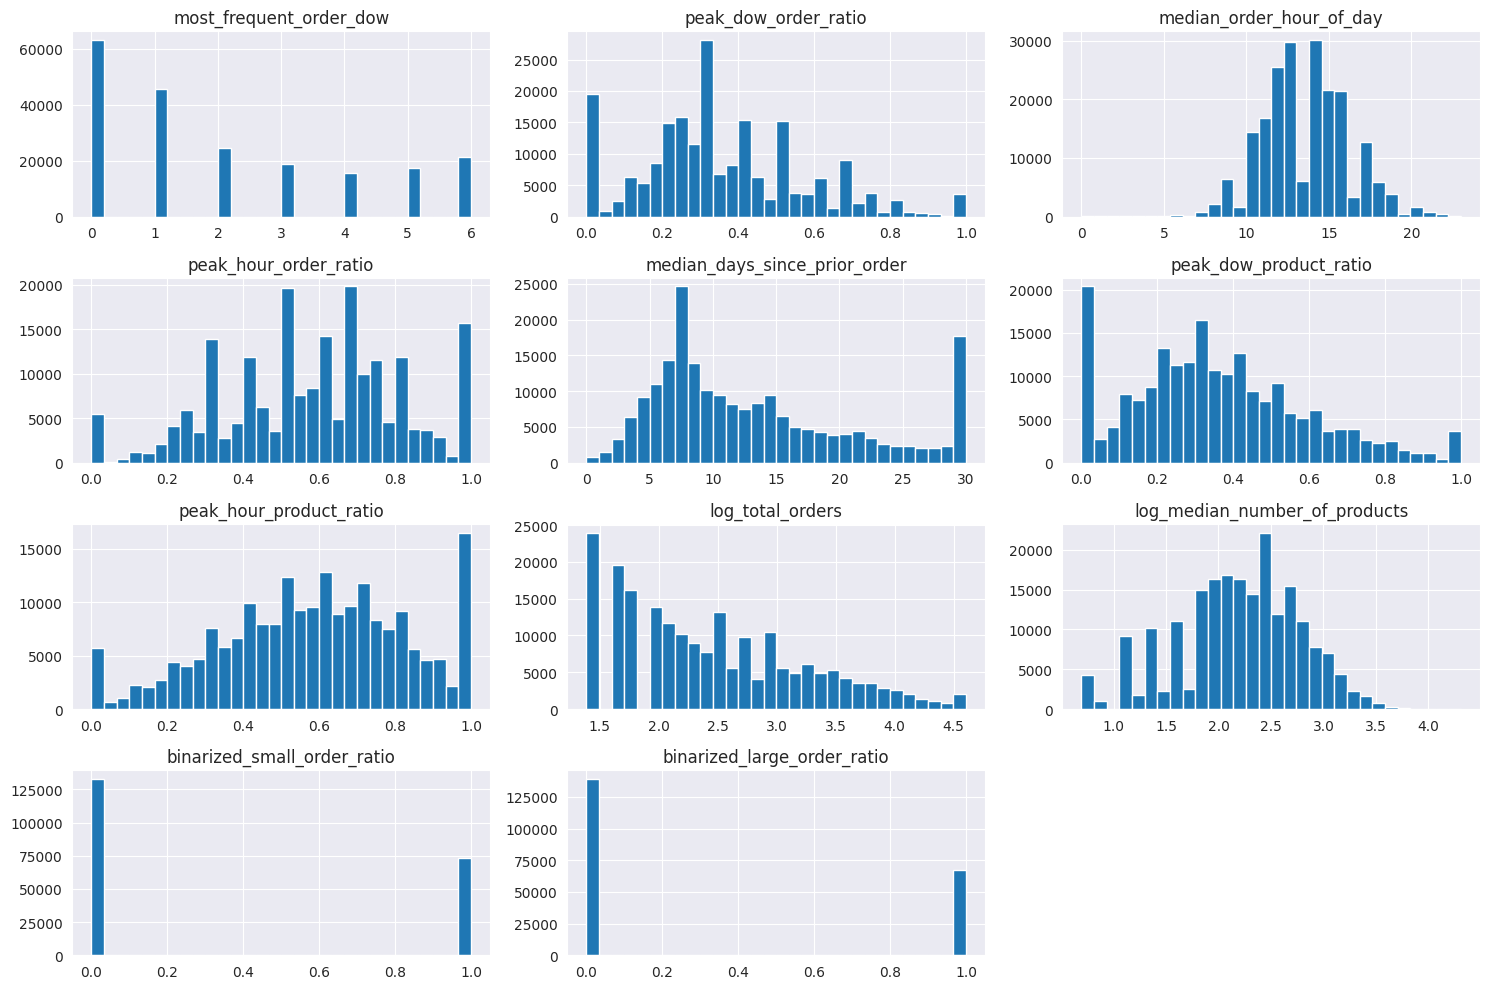

In [26]:
features.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

- Clustering algorithms are sensitive to the scale of the features.
- Let's Z-score normalize the features other than `most_frequent_order_dow`, and the binarized features.
- By doing Z-score normalization on ratios, we are loosing interpretability.

In [27]:
scaler = StandardScaler()
features_to_scale = features.drop(columns=['most_frequent_order_dow', 'binarized_small_order_ratio', 'binarized_large_order_ratio'])
scaled_features = scaler.fit_transform(features_to_scale)
scaled_features = pd.DataFrame(scaled_features, columns=features_to_scale.columns, index=features_to_scale.index)

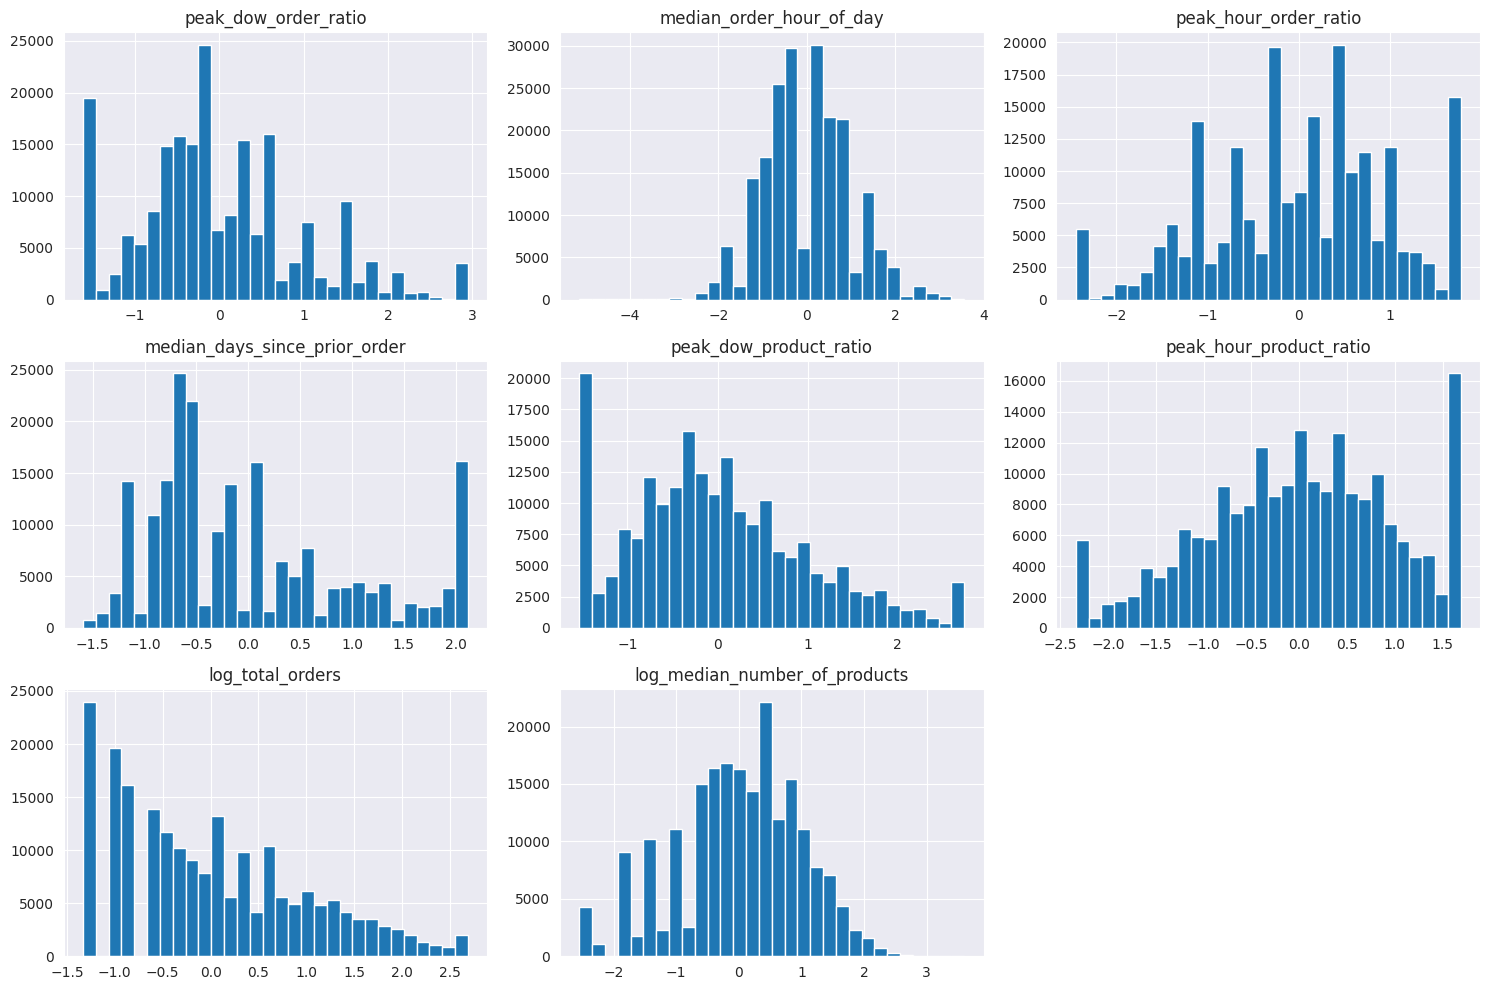

In [28]:
scaled_features.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [30]:
final_features = pd.concat([scaled_features, features[['most_frequent_order_dow', 'binarized_small_order_ratio', 'binarized_large_order_ratio']]], axis=1)
final_features.head()

,peak_dow_order_ratio,median_order_hour_of_day,peak_hour_order_ratio,median_days_since_prior_order,peak_dow_product_ratio,peak_hour_product_ratio,log_total_orders,log_median_number_of_products,most_frequent_order_dow,binarized_small_order_ratio,binarized_large_order_ratio
user_id,,,,,,,,,,,
1,-0.249493,-1.928557,-0.755826,0.818356,-0.295143,-0.646144,-0.070348,-0.545081,1,0,0
2,0.024542,-1.360230,0.893522,-0.171625,-0.124272,0.320386,0.316791,0.819427,1,0,1
3,1.440388,0.913080,0.005412,-0.357246,1.456288,-0.042063,0.138171,-0.191960,0,0,0
4,-1.619667,-0.223575,1.781633,0.261492,-1.533960,1.689637,-0.826933,-1.370759,4,1,0
5,0.663956,1.291965,-0.332916,-0.295372,0.900956,-0.162879,-1.054508,0.349617,3,0,0


Let's save the features to a CSV file.

In [31]:
final_features.to_csv('data/features.csv', index=True)